<a href="https://colab.research.google.com/github/ndbellew/KompyuterM3chakrs/blob/master/Tensorflow-Keras/Regression_TensorFlow_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression
> __Predict Fuel Efficiency__ - this example will use the Auto MPG data set to build a model prediction for the fuel efficiency of late-1970s and early 1980s automobiles. Our model description will include attributes like: cylinders, displacement, horsepower, and weight.

So now we are going to discuss _regression_. 
__Regression__ - a measure of the relation between the mean value of one variable and corresponding values of other variables.

__Regression Problem__(With respect to Machine Learning) - A problem where the solution is not always a single answer and may be a range of answers.

Wit regression we aim to predict the output of a continuous value. Such as the price or some probability. This is different from Tutorial 1 where we discussed a _classification problem_ where we aim to select a class from a list of classes. 

__Classification Problem__ - A problem where the solution involves a single answer, such as trying to determine what a picture is of.



## Included Libraries

In [38]:
!pip install -q seaborn# this is for pairplot.

ERROR: Invalid requirement: 'seaborn#'



In [39]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


### Libraries Discussion

* pathlib
> solves complexity when dealing with Pathing in Python3. This is just used so that when we consider pathing we don't need to write 20 lines to put information in specific places.
*matplotlib.pyplot
> This is for the pyplot feature, which is what we end up using for the visual aspect of data evaluation. This is our graphs, chrats, etc.
*pandas
> this is a library that provides high-performance, easy-to-use data structures and data analysis tools. This allows us to analyze our complex data a little easier.
*seaborn
> Similar to Pyplot but uses data visualiation based on matplotlib to provide a high level interface for statistical graph. To put it simple, it makes very pretty graphs.


## The Auto MPG Dataset

In [40]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [41]:
# import using pandas
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [42]:
# Clean the data
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
# Drop rows for simplicity
dataset = dataset.dropna()

In [0]:
#The "Origin" column is categorical, not numeric, so we convert it to a one-hot
# A one-hot is a way to turn something categorical into something binary, usually with matrices.
origin = dataset.pop('Origin')

In [45]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()
# As you can see this plots out a binary array where each country holds a location
# and the value 1 tells you if that is the origin country.


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Split the Data
Time for training and testing the data.


In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the Data
This is important ot view the data as if a human is seeing it.
this is where Seaborn is good to use. the only thing that stands out is the diag_kind variable.

* The diag_kind variable is merely to tell seaborn how to visualize the data, your options are auto, hist, and kde. kde gives us these clean graphs where hist would be more of a flat bar graph. Really it makes no difference only for the person veiwing the graph


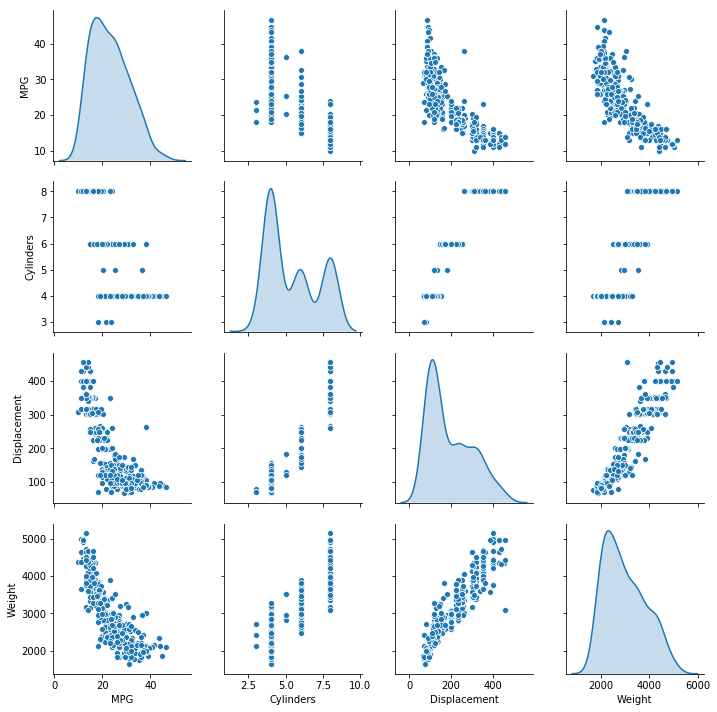

In [47]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [48]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


###  Split Features from Labels
It is important to seperate the target value or "label", from the features. This label is the value that you will train the model to predict

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the Data
As we can see from the _train_stats_ block, the ranges between each feature is quite massive. It is good practice to normalize features that use different scales and ranges. The model might converge without normaliztion, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input. 

##### Please Note
* Although we intentionally generate these statistics from only the training dataset, these stats will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

This is the normalized data that will be used to train the model however, 
> The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier. That includes the test set as well as live data when the model is used in production.


In [0]:
def norm(x):
  return(x-train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


## The Model
### Building the Model
For this model we will use _Sequential_ model with 2 densely connected hidden layers and an output layer that returns a single, continuous value. The model building steps are wrapped ina function, _build_model_, since we will create a second model later on.
### Notation
> Model types, there are 2 types Sequential is one for this example, it is a feed forward that determines if something is or is not. because we are setting up confidence intervals over a probability based on training data Sequential is the best choice here, after that we must develope how the Sequential Model is setup via Layers.

> Normally we would Use Flatten but because the data is already flat and we are just predicting the future we don't need to flatten it first.

__Dense__
> first how many units(Neurons), next the activation function - what makes the Neuron fire?. 

Each layer will be passed through but it is important to realize what the activation means.
> __tf.nn.relu__ is a standard Rectified Linearization of the model data. It is generally a standard that is commonplace for many models. 

> The final Layer will be a Dense but it does not contain our neurons but instead the number of classifications instead. 

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [0]:
model  = build_model()


### Inspect the Model
Well hey we built the thing now lets look at it. model.summary() should do the trick

In [53]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [54]:
# now to try the model out, we can use some batch lets say 10. 
# this will take 10 examples from the training data and predict what they are.
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.6126952 ],
       [-0.57312477],
       [-1.2457833 ],
       [-0.77745473],
       [-0.6994034 ],
       [-0.6460871 ],
       [-0.6880034 ],
       [-0.579311  ],
       [-0.44112593],
       [-1.1125479 ]], dtype=float32)

## Train the Model
after crafting our model now its time to teach it how to read. For this one we will risk over-fitting and use 1000 epochs to train and validate the accuracy in the _history_ object

we will create the PrintDot object so we can avoid seeing the  [===>----] graphic 1000 times. 
 
 then we will just fit the model so that it gives us our answer. 

In [55]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [56]:
# Alright but what does this look like?
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.263281,0.919475,2.263281,8.971139,2.338837,8.971139,995
996,2.177871,0.925765,2.177871,8.734161,2.314738,8.734160,996
997,2.327614,0.930044,2.327614,8.396993,2.277072,8.396993,997
998,2.168009,0.930669,2.168009,9.205660,2.366513,9.205660,998
999,2.273645,0.954035,2.273645,8.906495,2.321936,8.906495,999


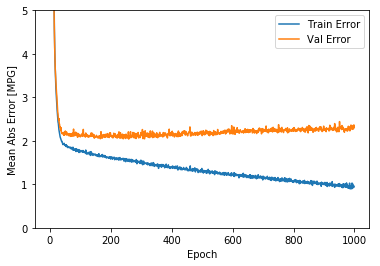

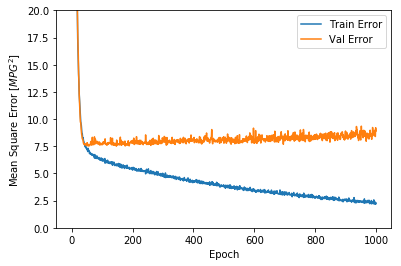

In [57]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

These graphs show that although the training for the model was intense, it clearly was over-fitted around the 100 epoch mark, after which the validation, which is our end goal, flattened out. We must, therefore, update the _model.fit_ call to automatically stop training when/if the validation score does not imporve. 

To do this we will be suing the _EarlyStopping callback_ that tests for a trining condition on each epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training. 

__EarlyStopping__ takes 7 arguments.
* __monitor__: quantity to be monitored.
* __min_delta__: minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
* __patience__: number of epochs with no improvement after which training will be stopped.
* __verbose__: verbosity mode.
* __mode__: one of {auto, min, max}. In min mode, training will stop when the quantity monitored has stopped decreasing; in max mode it will stop when the quantity monitored has stopped increasing; in auto mode, the direction is automatically inferred from the name of the monitored quantity.
* __baseline__: Baseline value for the monitored quantity to reach. Training will stop if the model doesn't show improvement over the baseline.
* __restore_best_weights__: whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.

As a whole you decide what is best for the model, this should result in a +/- 2 result for MPG whether or not that is good is completely up to you. 


.......................................................

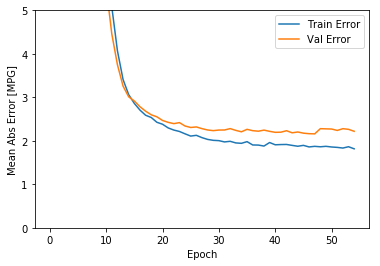

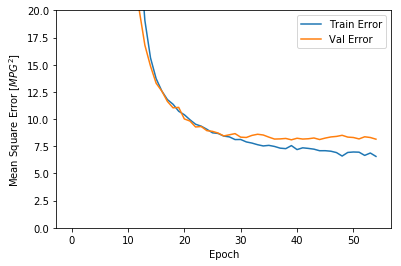

In [59]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [60]:
# How does this model generalize using the test set?
# This tells us how well we can expect the model to predict when we use it in production
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.82 MPG


## Make Predictions
The model has been created, trained, and now it needs to give us predictions to show what it has learned. Along with its predictions, we must also look at the error distribution. 

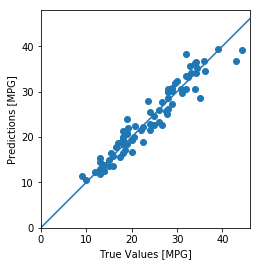

In [62]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

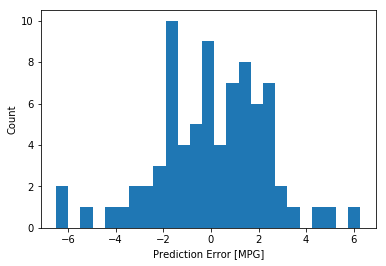

In [63]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

although it does not quite look like a good bell curve for an error prediction, we are only using a small amount of samples, the more samples, the more training, the better the validation, the better the error. 

## Conclusion
This was to help understand how to use in a Regression problem. 
* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean  Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.


In [0]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.